# UCLA SWE Reanalysis Data Access

This workbook is to access the Western United States snow reanalysis data set, as developed by UCLA. Normally, the data is provided as PNG or netCDF files, but here we will access is directly through NSIDC.

This workbook is adapted from Eric Gagliano's `easysnowdata` package: https://github.com/egagli/easysnowdata/. If not installed yet, run the below cell, and restart the kernel.

In [1]:
%pip install easysnowdata

  Using cached easysnowdata-0.0.19-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached planetary_computer-1.0.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached odc_stac-0.3.11-py3-none-any.whl.metadata (5.2 kB)
  Using cached xee-0.0.20-py3-none-any.whl.metadata (6.2 kB)
  Using cached py3dep-0.19.0-py3-none-any.whl.metadata (21 kB)
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached pytkdocs-0.16.5-py3-none-any.whl.metadata (8.7 kB)
  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
  Using cached odc_geo-0.4.10-py3-none-any.whl.metadata (6.1 kB)
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached async_retriever-0.19.3-py3-none-any.whl.metadata (16 kB)
  Using cached pygeoogc-0.19.3-py3-none-any.whl.metadata (18 kB)
  Using cached pygeoutils-0.19.5-py3-none-any.whl.metadata (12 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadat

In [2]:
import xarray as xr
import earthaccess
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

In [3]:
bbox = (-119.85, 37.71, -119.1, 38.25)

# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

# Search for the granule by DOI
results = earthaccess.search_data(
    doi='10.5067/PP7T2GBI52I2',
    temporal=("2020-10-01", "2021-09-30"),
    bounding_box = bbox,
    cloud_hosted=True
)

In [19]:
display(results)

[Collection: {'EntryTitle': 'Western United States UCLA Daily Snow Reanalysis V001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -119.998, 'EastBoundingCoordinate': -119.001, 'NorthBoundingCoordinate': 37.9978, 'SouthBoundingCoordinate': 37.0023}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-10-01T00:00:00.000Z', 'EndingDateTime': '2021-09-30T23:59:59.000Z'}}
 Size(MB): 135.871
 Data: ['https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/2020.10.01/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc'],
 Collection: {'EntryTitle': 'Western United States UCLA Daily Snow Reanalysis V001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -119.998, 'EastBoundingCoordinate': -119.001, 'NorthBoundingCoordinate': 38.9978, 'SouthBoundingCoordinate': 38.0023}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-10

In [4]:
files = earthaccess.open(results)
files

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/2020.10.01/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/2020.10.01/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2020_21_SWE_SCA_POST.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/2020.10.01/WUS_UCLA_SR_v01_N38_0W120_0_agg_16_WY2020_21_SD_POST.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP6/SNOWEX/WUS_UCLA_SR.001/2020.10.01/WUS_UCLA_SR_v01_N37_0W120_0_agg_16_WY2020_21_SD_POST.nc>]

In [16]:
ds = xr.open_mfdataset(files).transpose()

In [20]:
ds.sel(Stats=0)

<xarray.Dataset> Size: 443MB
Dimensions:    (Latitude: 450, Longitude: 225, Day: 365)
Coordinates:
  * Latitude   (Latitude) float32 2kB 39.0 38.99 38.99 ... 37.01 37.01 37.0
  * Longitude  (Longitude) float32 900B -120.0 -120.0 -120.0 ... -119.0 -119.0
Dimensions without coordinates: Day
Data variables:
    SWE_Post   (Latitude, Longitude, Day) float32 148MB dask.array<chunksize=(225, 225, 1), meta=np.ndarray>
    SCA_Post   (Latitude, Longitude, Day) float32 148MB dask.array<chunksize=(225, 225, 1), meta=np.ndarray>
    SD_Post    (Latitude, Longitude, Day) float32 148MB dask.array<chunksize=(225, 225, 1), meta=np.ndarray>

In [7]:
import re
import pandas as pd

url = files[0].path
date_pattern = r'\d{4}\.\d{2}\.\d{2}'
WY_start_date = pd.to_datetime(re.search(date_pattern, url).group())

In [9]:
ds.coords['time'] = ("Day", pd.date_range(WY_start_date, periods=ds.sizes['Day']))
ds = ds.swap_dims({'Day':'time'})

In [11]:
ds = ds.sel(time=slice('2020-10-01', '2021-09-30'))

In [13]:
stats_dictionary = {'mean':0, 'std':1, 'median':2, '25pct':2, '75pct':3}
stats_index = stats_dictionary['mean']

In [14]:
ds = ds['SWE_Post'].sel(Stats=stats_index)

In [15]:
ds

<xarray.DataArray 'SWE_Post' (Latitude: 450, Longitude: 225, time: 365)> Size: 148MB
dask.array<getitem, shape=(450, 225, 365), dtype=float32, chunksize=(225, 225, 1), chunktype=numpy.ndarray>
Coordinates:
  * Latitude   (Latitude) float32 2kB 39.0 38.99 38.99 ... 37.01 37.01 37.0
  * Longitude  (Longitude) float32 900B -120.0 -120.0 -120.0 ... -119.0 -119.0
  * time       (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
Attributes:
    Units:    meters

In [21]:
import easysnowdata as esd
import geopandas as gpd

As implied by the dataset's name, the UCLA reanalysis is only for the Western United States. For this example, we will look over the Tuolumne River Basin in California.

In [22]:
bbox_gdf = gpd.read_file("/home/jovyan/shared-public/SnowPit/tuolumne_basin_v2.geojson")
bbox_gdf

,geometry
0,"POLYGON ((-119.85 37.71, -119.1 37.71, -119.1 ..."


With `easysnowdata`, accessing the reanalysis data only requires a single cell of code. We give the called function our bounding box, a start date and end date, and the variable and statistic of interest.

Possible inputs for `variable`:
* `SWE_Post`: Snow water equivalent, in meters (default)
* `SCA_Post`: Snow covered area
* `SD_Post`: Snow depth, in meters

Possible inputs for `stats`:
* `mean`: Default setting
* `std`: Standard deviation
* `median`
* `25pct`: 25th percentile
* `75pct`: 75th percentile

In [23]:
snow_reanalysis_da = esd.hydroclimatology.get_ucla_snow_reanalysis(
    bbox_gdf,
    start_date="2020-10-01",
    end_date="2021-09-30",
    variable="SWE_Post",
    stats="mean",
)

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
snow_reanalysis_da

<xarray.DataArray 'SWE_Post' (Latitude: 123, Longitude: 170, time: 365)> Size: 31MB
dask.array<getitem, shape=(123, 170, 365), dtype=float32, chunksize=(66, 170, 1), chunktype=numpy.ndarray>
Coordinates:
  * Latitude     (Latitude) float32 492B 38.25 38.25 38.24 ... 37.72 37.71 37.71
  * Longitude    (Longitude) float32 680B -119.9 -119.8 -119.8 ... -119.1 -119.1
  * time         (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
    spatial_ref  int64 8B 0
Attributes:
    Units:          meters
    data_citation:  Fang, Y., Liu, Y. & Margulis, S. A. (2022). Western Unite...

We now have daily-averaged SWE data over the Tuolumne! 

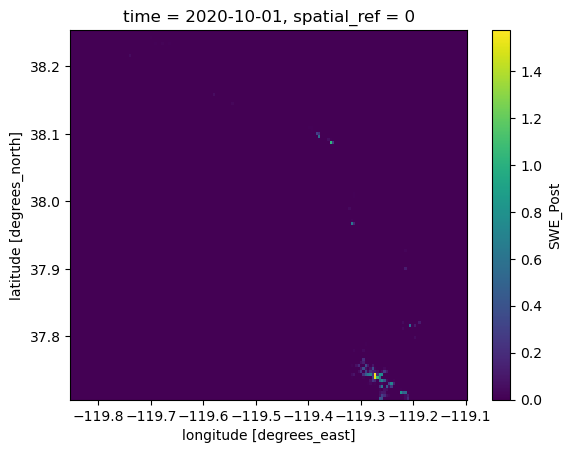

In [29]:
snow_reanalysis_da.isel(time=0).compute()

In [30]:
snow_reanalysis_monthly = snow_reanalysis_da.resample(time="M").mean()
snow_reanalysis_monthly

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'SWE_Post' (Latitude: 123, Longitude: 170, time: 12)> Size: 1MB
dask.array<groupby_nanmean, shape=(123, 170, 12), dtype=float32, chunksize=(66, 170, 1), chunktype=numpy.ndarray>
Coordinates:
  * Latitude     (Latitude) float32 492B 38.25 38.25 38.24 ... 37.72 37.71 37.71
  * Longitude    (Longitude) float32 680B -119.9 -119.8 -119.8 ... -119.1 -119.1
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 96B 2020-10-31 2020-11-30 ... 2021-09-30
Attributes:
    Units:          meters
    data_citation:  Fang, Y., Liu, Y. & Margulis, S. A. (2022). Western Unite...

**Caution**: The below plotting cell can be quite slow if you plot more than one figure at a time. It's not memory-intensive, just time-consuming.


KeyboardInterrupt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ff0661b1c90>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Error in callback <function _draw_all_if_interactive at 0x7ff01f422520> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <function _SelectorTransport.__del__ at 0x7ff067f4b2e0>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.11/asyncio/selector_events.py", line 866, in __del__
    def __del__(self, _warn=warnings.warn):

KeyboardInterrupt: 


KeyboardInterrupt: 

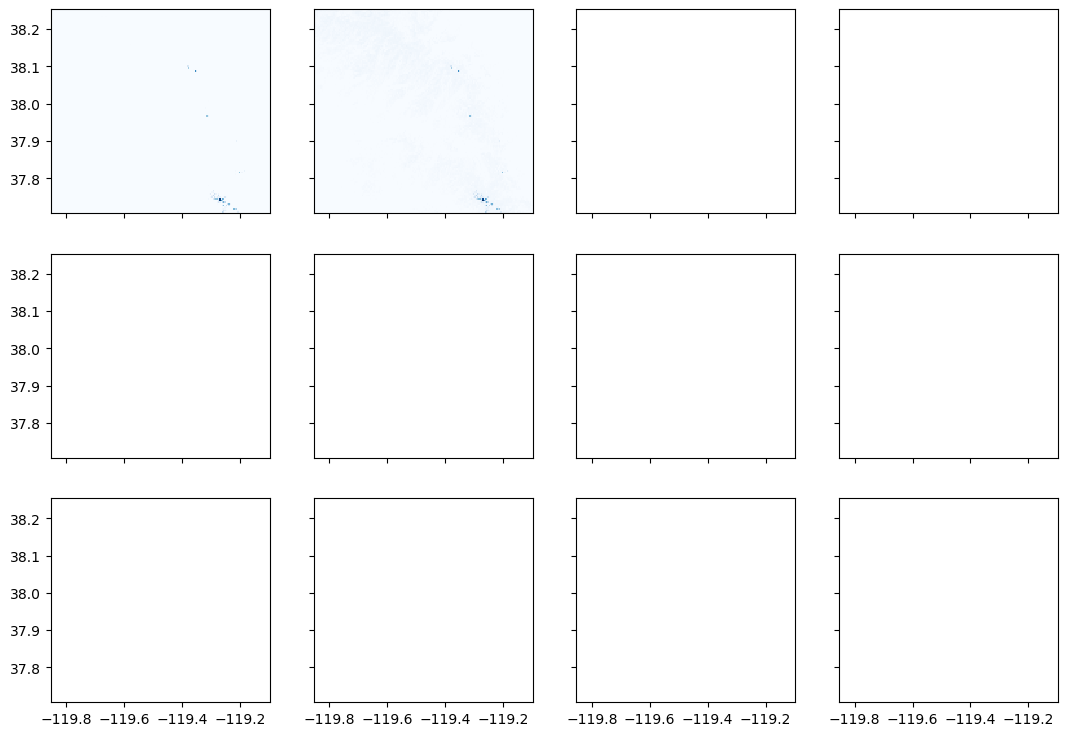

In [33]:
%%time
#for i in range(13):
#    snow_reanalysis_monthly.isel(time=i).compute()
    
f = snow_reanalysis_monthly.plot.imshow(
    col='time',
    col_wrap=4,
    cmap="Blues",
    vmin=0,
    vmax=1.5,
)

#f.fig.suptitle("UCLA SWE reanalysis")